<a href="https://colab.research.google.com/github/samy387/Arabian/blob/main/updated_codee_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print("Is GPU available:", tf.config.list_physical_devices('GPU'))

Is GPU available: []


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import warnings
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from PIL import Image

In [ ]:
# Suppress Keras warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [ ]:
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/brain-tumor-mri-dataset


In [ ]:
# Define paths to dataset
train_dir = os.path.join(path, 'Training')
test_dir = os.path.join(path, 'Testing')

In [ ]:
# Verify directory existence
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError(f"Dataset directories not found: {train_dir}, {test_dir}")

In [ ]:
# Create DataFrame for visualization
def create_dataset_df(directory):
    data = {'filename': [], 'label': []}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            for img_name in os.listdir(class_dir):
                data['filename'].append(os.path.join(class_name, img_name))
                data['label'].append(class_name)
    return pd.DataFrame(data)

In [ ]:
# Load training dataset DataFrame
df = create_dataset_df(train_dir)

In [ ]:
# Sample 5 images per class with replacement
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
samples = []
for class_name in class_names:
    class_samples = df[df['label'] == class_name].sample(5, replace=True)
    samples.append(class_samples)
combined_samples = pd.concat(samples).reset_index(drop=True)

In [ ]:
import cv2
def preprocess_image(img):
    # Gaussian blur for noise reduction
    img = cv2.GaussianBlur(img, (5, 5), 0)
    # CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(img)
    return img

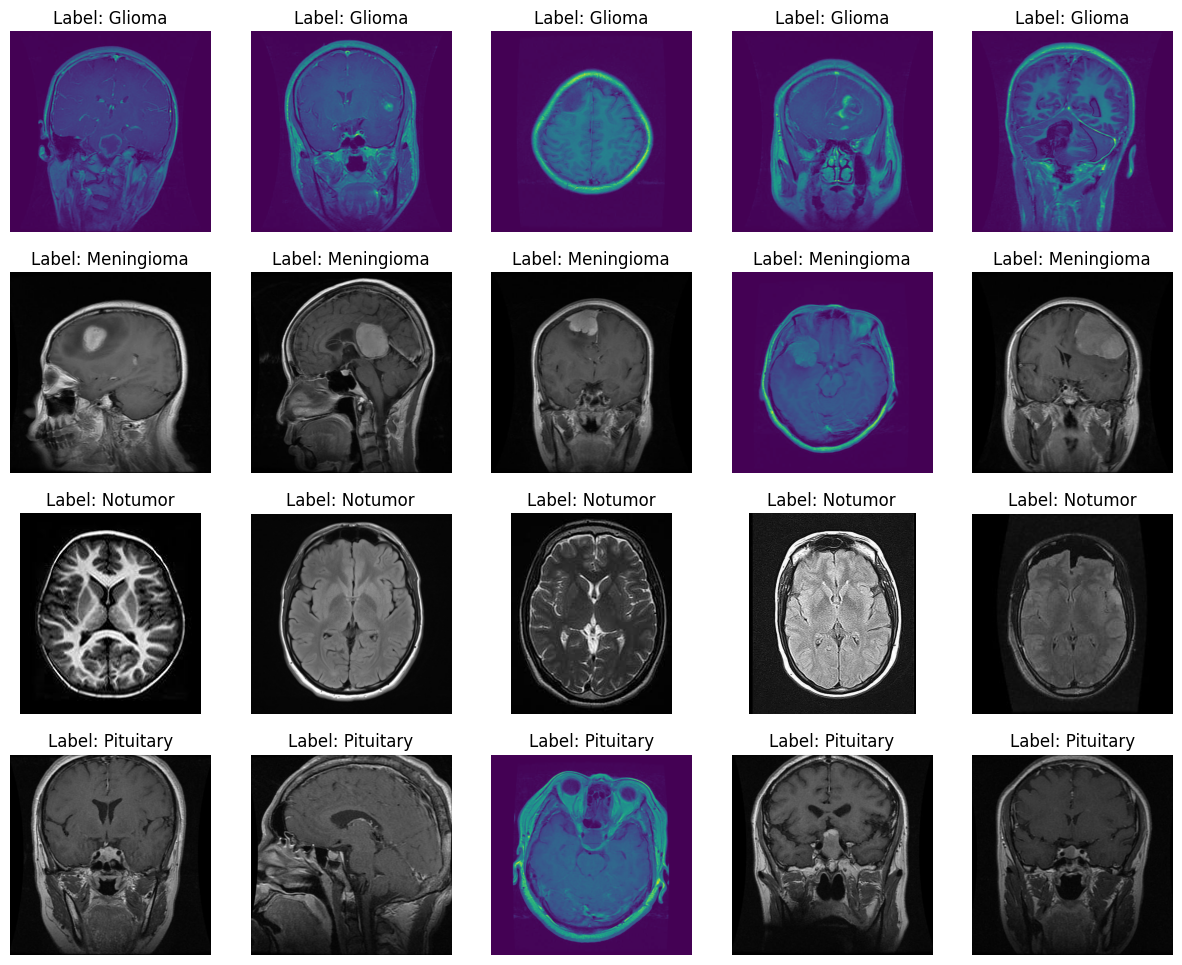

In [ ]:
# Visualize sample images
plt.figure(figsize=(15, 12))
for i, row in combined_samples.iterrows():
    img_path = os.path.join(train_dir, row['filename'])
    img = Image.open(img_path)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {row['label'].capitalize()}")
    plt.axis('off')
plt.savefig('sample_images.png')
plt.show()
plt.close()

In [ ]:
# Preprocessing: ImageDataGenerator with ResNet50 preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
# Load training and testing data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=16,  # Reduced for Colab GPU
    class_mode='categorical',
    color_mode='rgb',
    shuffle=True
)

Found 5712 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)

Found 1311 images belonging to 4 classes.


In [ ]:
# Print class indices
print("Class indices:", train_generator.class_indices)

Class indices: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Cache dataset for faster training
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, 4])
).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = tf.data.Dataset.from_generator(
    lambda: test_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, 224, 224, 3], [None, 4])
).cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Feature Extraction: Load pretrained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [ ]:
# Freeze convolutional base
base_model.trainable = False

In [ ]:
# Add custom layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

In [ ]:
# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Checkpoint to save best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')

In [ ]:
# Train model
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=test_generator,
    verbose=1
)

Epoch 1/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 1226s 3s/step - accuracy: 0.7007 - loss: 0.7904 - val_accuracy: 0.8452 - val_loss: 0.3885
Epoch 2/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 1201s 3s/step - accuracy: 0.8546 - loss: 0.3958 - val_accuracy: 0.8421 - val_loss: 0.4031
Epoch 3/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 1191s 3s/step - accuracy: 0.8684 - loss: 0.3466 - val_accuracy: 0.8726 - val_loss: 0.3245
Epoch 4/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 1194s 3s/step - accuracy: 0.8840 - loss: 0.3104 - val_accuracy: 0.8810 - val_loss: 0.3105
Epoch 5/5
357/357 ━━━━━━━━━━━━━━━━━━━━ 1194s 3s/step - accuracy: 0.8872 - loss: 0.3046 - val_accuracy: 0.8947 - val_loss: 0.2755


In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

82/82 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.8824 - loss: 0.3026
Test Accuracy: 0.8947
Test Loss: 0.2755


In [ ]:
# Predictions for confusion matrix and classification report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

82/82 ━━━━━━━━━━━━━━━━━━━━ 232s 3s/step


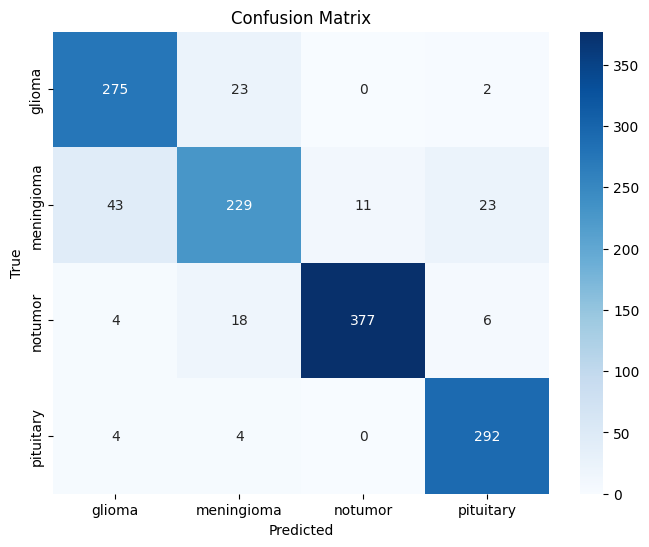

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
class_names = list(train_generator.class_indices.keys())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      glioma       0.84      0.92      0.88       300
  meningioma       0.84      0.75      0.79       306
     notumor       0.97      0.93      0.95       405
   pituitary       0.90      0.97      0.94       300

    accuracy                           0.89      1311
   macro avg       0.89      0.89      0.89      1311
weighted avg       0.90      0.89      0.89      1311



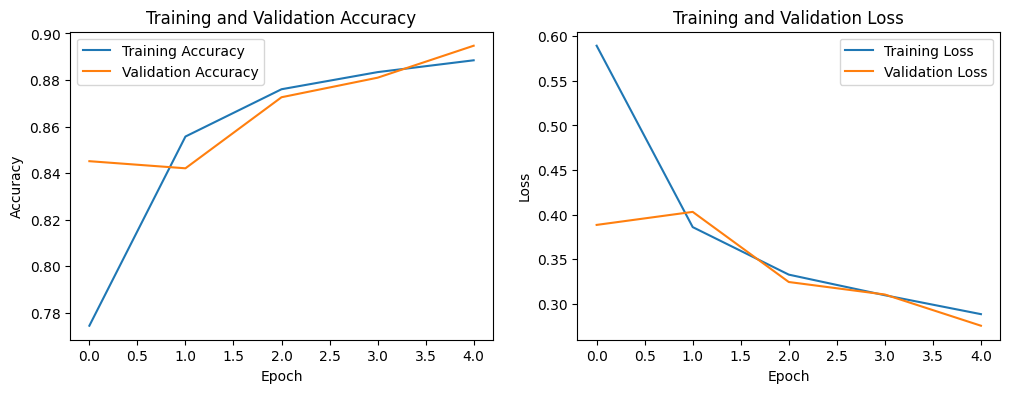

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()